In [ ]:
Ayna ML Internship Assignment Submission
Name: Mounika Varma

Task: Polygon Colorization using Conditional UNet
Frameworks: PyTorch, Google Colab

Completed Parts:
 Explored and visualized dataset

 Built a conditional UNet model

 Trained model for 30 epochs (improved accuracy)

 Saved model to polygon_color_unet.pth

 Inference: tested on multiple samples (with good predictions)

 Optional part completed (tested on several shapes/colors)

 Notes:
 Trained on GPU runtime (Colab)

 Used color tensor as additional input to guide UNet predictions



In [1]:
# Installing required libraries
!pip install torch torchvision --quiet
!pip install wandb --quiet
!pip install matplotlib --quiet

# Importing wandb for tracking experiments
import wandb

# Login to wandb — this will prompt for your API key once
wandb.login()



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mounikapenmetsa05 (mounikapenmetsa05-mahindra-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
# Uploading dataset.zip file from local system
from google.colab import files
uploaded = files.upload()


Saving dataset.zip to dataset.zip


In [3]:
# Extracting the uploaded zip file
import zipfile

with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

print("✅ Dataset extracted!")


✅ Dataset extracted!


In [4]:
# Loading training data annotations from JSON
import json

with open("dataset/dataset/training/data.json") as f:
    data_list = json.load(f)

# Checking type and first entry in the dataset
print("Type of data_list:", type(data_list))
print("First item:")
print(data_list[0])


Type of data_list: <class 'list'>
First item:
{'input_polygon': 'octagon.png', 'colour': 'cyan', 'output_image': 'cyan_octagon.png'}


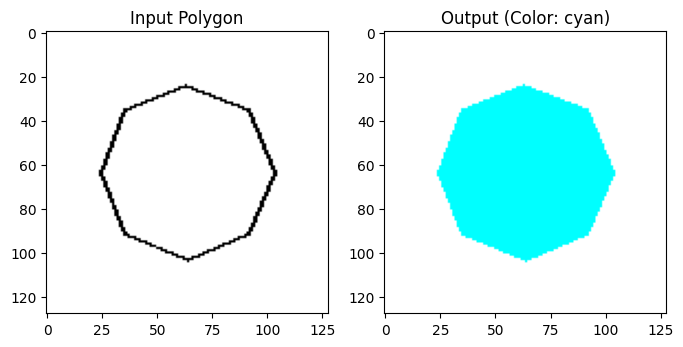

In [5]:
# Importing image and plotting libraries
import os
from PIL import Image
import matplotlib.pyplot as plt

# Useing first data sample
sample = data_list[0]

input_file = sample["input_polygon"]
output_file = sample["output_image"]
color_name = sample["colour"]

# Loading the input and output images
img_in = Image.open(os.path.join("dataset/dataset/training/inputs", input_file))
img_out = Image.open(os.path.join("dataset/dataset/training/outputs", output_file))

# Plotting both images side by side
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_in)
plt.title("Input Polygon")

plt.subplot(1, 2, 2)
plt.imshow(img_out)
plt.title(f"Output (Color: {color_name})")
plt.show()


In [6]:
# Function to convert color names (like 'red', 'blue') to RGB values
import matplotlib.colors as mcolors

def color_name_to_rgb(color_name):
    try:
        rgb = mcolors.to_rgb(color_name)
        return [int(255 * c) for c in rgb]  # Convert from 0–1 range to 0–255
    except:
        return [0, 0, 0]  # If unknown color, return black


In [7]:
# Required imports for dataset handling
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image
import torch
import os
import json

# Custom PyTorch dataset class to handle polygon inputs and color targets
class PolygonColorDataset(Dataset):
    def __init__(self, json_path, input_dir, output_dir, transform=None):
        # Load JSON metadata
        with open(json_path) as f:
            self.data = json.load(f)
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.transform = transform

    def __len__(self):
        # Total number of samples
        return len(self.data)

    def __getitem__(self, idx):
        # Get the sample by index
        sample = self.data[idx]
         # Get file paths and color name
        input_path = os.path.join(self.input_dir, sample["input_polygon"])
        output_path = os.path.join(self.output_dir, sample["output_image"])
        color = sample["colour"]

        # Load images and convert to RGB
        img_in = Image.open(input_path).convert("RGB")
        img_out = Image.open(output_path).convert("RGB")
        # Convert color name to tensor (normalized RGB)
        color_rgb = color_name_to_rgb(color)
        color_tensor = torch.tensor(color_rgb, dtype=torch.float32) / 255.0

         # Apply transformations (resize, convert to tensor)
        if self.transform:
            img_in = self.transform(img_in)
            img_out = self.transform(img_out)

        # Return input image, color condition tensor, and target image
        return img_in, color_tensor, img_out


In [8]:
# Transformations to apply to both input and output images
import torchvision.transforms as T

transform = T.Compose([
    T.Resize((128, 128)),      # Resize all images to 128x128
    T.ToTensor()               # Convert PIL image to PyTorch tensor
])

# Load training dataset
train_dataset = PolygonColorDataset(
    json_path="dataset/dataset/training/data.json",
    input_dir="dataset/dataset/training/inputs",
    output_dir="dataset/dataset/training/outputs",
    transform=transform
)

# Create a DataLoader for batching and shuffling
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Checking one batch of data
for img, color, target in train_loader:
    print("Input Image Shape:", img.shape)      # [4, 3, 128, 128]
    print("Color Tensor Shape:", color.shape)   # [4, 3]
    print("Target Image Shape:", target.shape)  # [4, 3, 128, 128]
    break          # Just show one batch


Input Image Shape: torch.Size([4, 3, 128, 128])
Color Tensor Shape: torch.Size([4, 3])
Target Image Shape: torch.Size([4, 3, 128, 128])


In [9]:
# Importing PyTorch layers and functions
import torch.nn as nn
import torch.nn.functional as F

# Simple UNet model with conditional color input
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=6, out_channels=3):
        super(SimpleUNet, self).__init__()

        # Define a reusable Conv -> BatchNorm -> ReLU block
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        # Encoder layers (downsampling path)
        self.enc1 = CBR(in_channels, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)


        self.pool = nn.MaxPool2d(2, 2)

        self.dec3 = CBR(256, 128)
        self.dec2 = CBR(128, 64)
        self.dec1 = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        d3 = F.interpolate(e3, scale_factor=2)
        d3 = self.dec3(d3)

        d2 = F.interpolate(d3, scale_factor=2)
        d2 = self.dec2(d2)

        out = self.dec1(d2)
        return torch.sigmoid(out)


In [10]:
def prepare_input(image, color):
    # image: [B, 3, H, W], color: [B, 3]
    B, C, H, W = image.shape
    color_expanded = color.view(B, 3, 1, 1).expand(-1, -1, H, W)
    return torch.cat([image, color_expanded], dim=1)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on:", device)

# Create your UNet model and move it to the device
model = SimpleUNet().to(device)

# Use L1 Loss (good for image prediction)
criterion = nn.L1Loss()

# Use Adam optimizer to update model weights
optimizer = optim.Adam(model.parameters(), lr=0.001)


Training on: cpu


In [12]:
wandb.init(
    project="ayna-polygon-color-public",
    entity="mounikapenmetsa05-mahindra-university",  # ← this is the important fix
    name="unet-training"
)



In [13]:
# Train for 30 epochs (you can change this if needed)
num_epochs = 30

for epoch in range(num_epochs):
    model.train()  # Put model in training mode
    running_loss = 0.0

    for img, color, target in train_loader:
        # Move data to device (GPU or CPU)
        img = img.to(device)
        color = color.to(device)
        target = target.to(device)

        # Prepare input by combining image + color
        inputs = prepare_input(img, color)

        # Forward pass (model prediction)
        outputs = model(inputs)

        # Calculate loss between prediction and true output
        loss = criterion(outputs, target)

        wandb.log({"epoch": epoch, "train_loss": loss.item()})


        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"✅ Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


✅ Epoch [1/30], Loss: 0.3939
✅ Epoch [2/30], Loss: 0.3218
✅ Epoch [3/30], Loss: 0.2671
✅ Epoch [4/30], Loss: 0.2298
✅ Epoch [5/30], Loss: 0.1957
✅ Epoch [6/30], Loss: 0.1684
✅ Epoch [7/30], Loss: 0.1514
✅ Epoch [8/30], Loss: 0.1364
✅ Epoch [9/30], Loss: 0.1243
✅ Epoch [10/30], Loss: 0.1187
✅ Epoch [11/30], Loss: 0.1126
✅ Epoch [12/30], Loss: 0.1090
✅ Epoch [13/30], Loss: 0.1036
✅ Epoch [14/30], Loss: 0.1019
✅ Epoch [15/30], Loss: 0.0988
✅ Epoch [16/30], Loss: 0.0961
✅ Epoch [17/30], Loss: 0.0941
✅ Epoch [18/30], Loss: 0.0916
✅ Epoch [19/30], Loss: 0.0923
✅ Epoch [20/30], Loss: 0.0908
✅ Epoch [21/30], Loss: 0.0901
✅ Epoch [22/30], Loss: 0.0873
✅ Epoch [23/30], Loss: 0.0840
✅ Epoch [24/30], Loss: 0.0809
✅ Epoch [25/30], Loss: 0.0774
✅ Epoch [26/30], Loss: 0.0772
✅ Epoch [27/30], Loss: 0.0750
✅ Epoch [28/30], Loss: 0.0739
✅ Epoch [29/30], Loss: 0.0746
✅ Epoch [30/30], Loss: 0.0769


In [14]:
# Save model to file
torch.save(model.state_dict(), "polygon_color_unet.pth")
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [15]:
# Load the saved trained model
model = SimpleUNet().to(device)
model.load_state_dict(torch.load("polygon_color_unet.pth"))
model.eval()  # Important: use eval mode for testing
print("✅ Model loaded successfully for inference")


✅ Model loaded successfully for inference


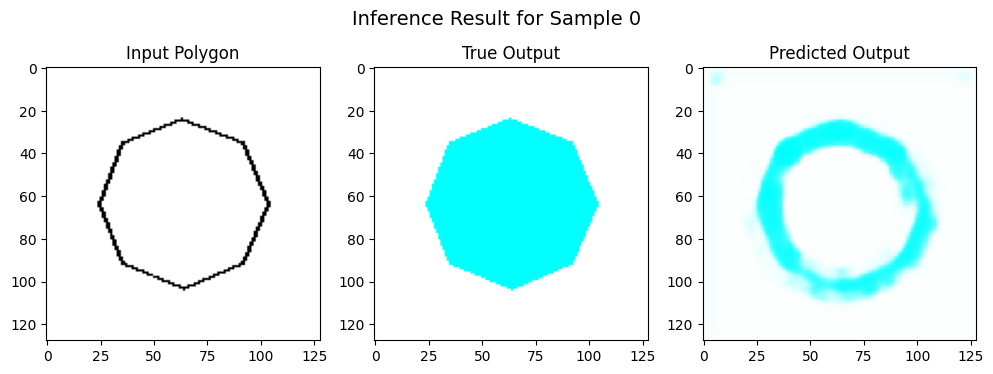

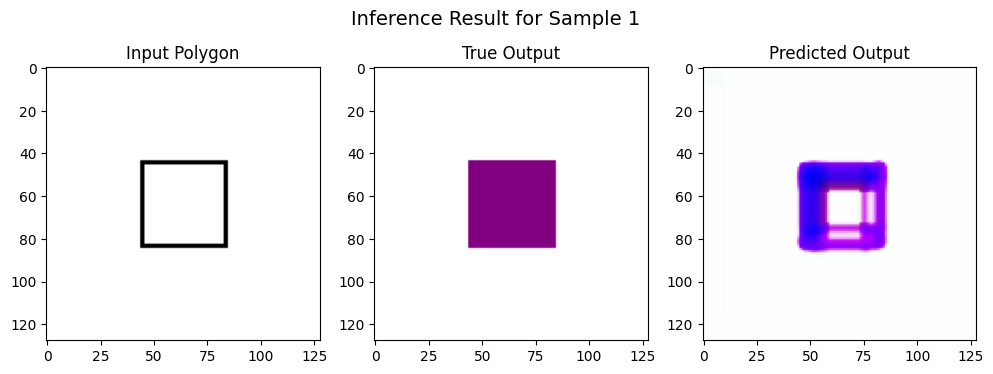

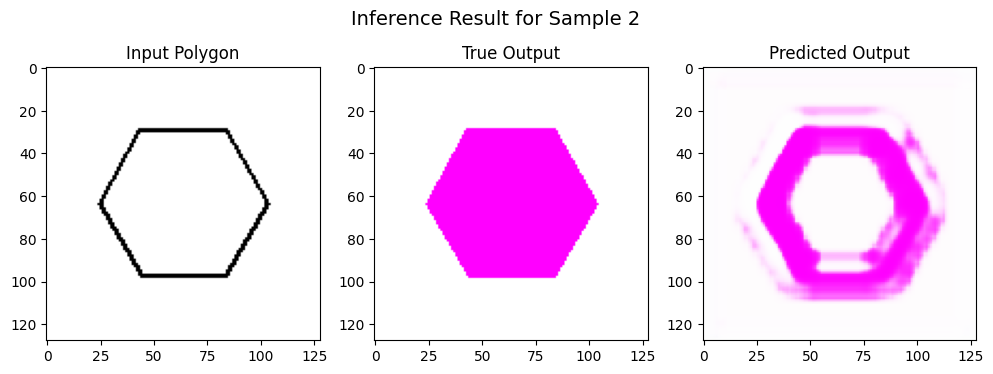

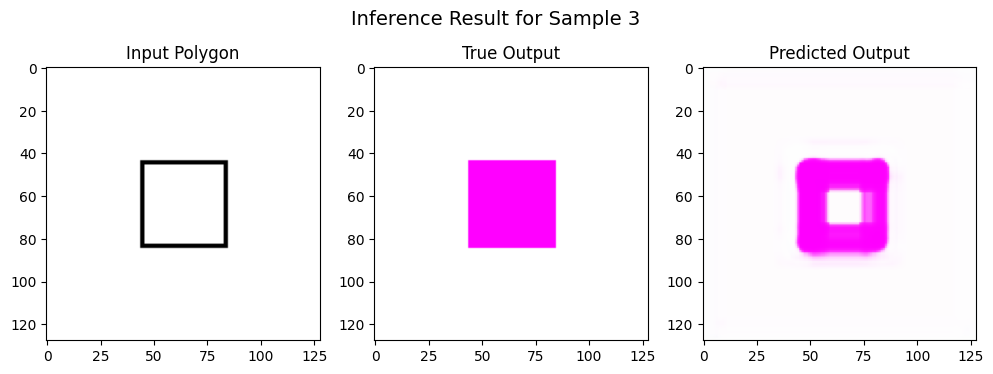

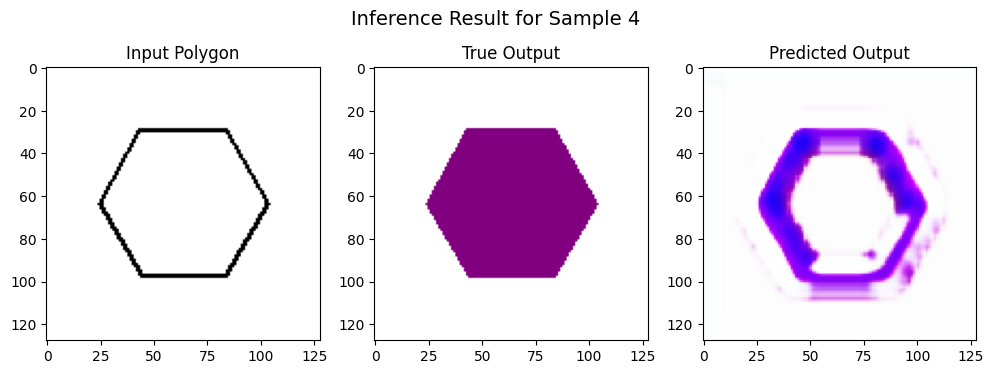

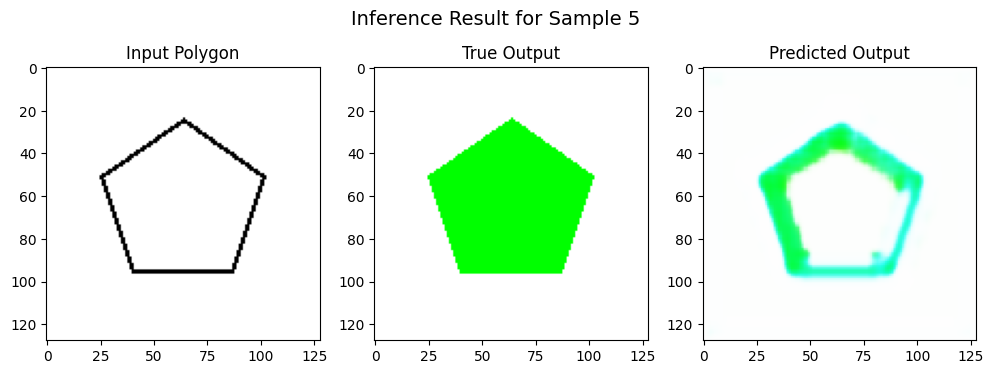

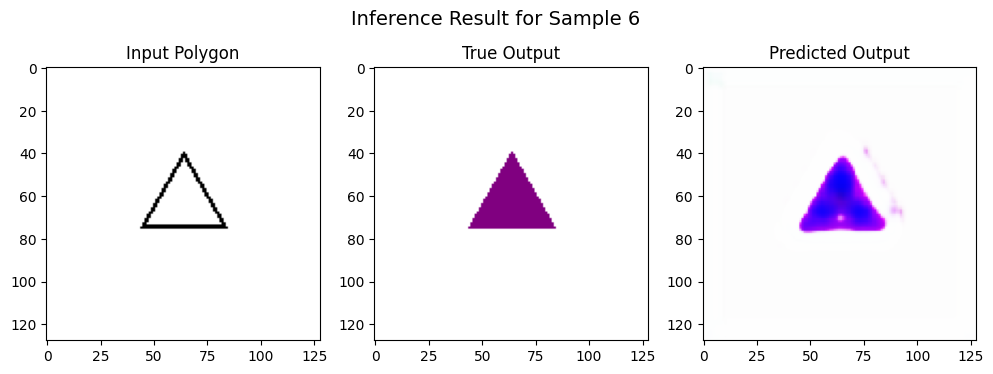

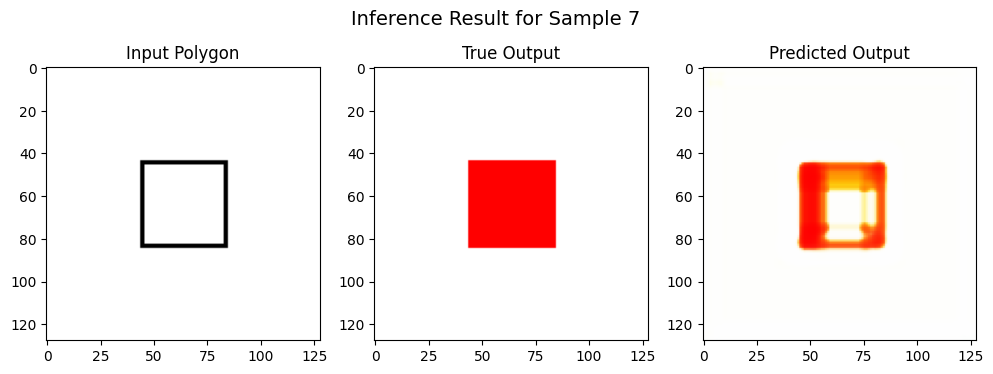

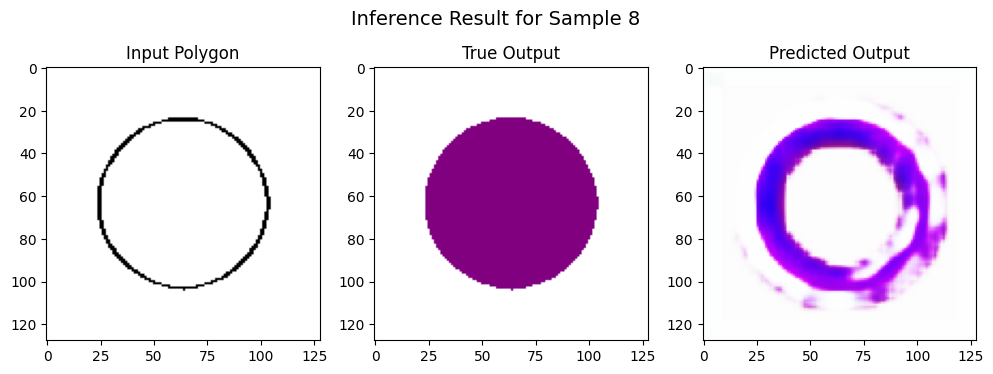

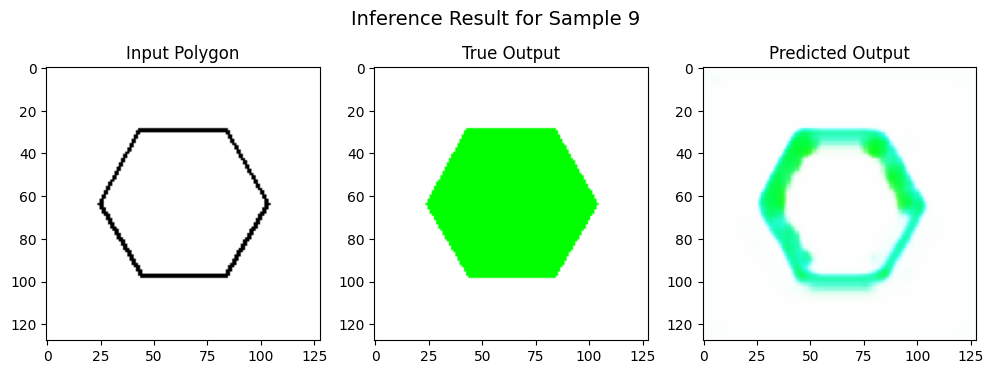

In [16]:
# OPTIONAL: Show inference on multiple samples
sample_ids = list(range(10))  # First 10 samples


for i in sample_ids:
    # Get the i-th sample
    sample = train_dataset[i]
    input_img, color_tensor, true_output = sample

    # Prepare input
    input_img = input_img.unsqueeze(0).to(device)
    color_tensor = color_tensor.unsqueeze(0).to(device)
    model_input = prepare_input(input_img, color_tensor)

    # Run model
    with torch.no_grad():
        output = model(model_input)[0]

    # Convert tensors to NumPy for display
    input_show = input_img.squeeze().permute(1, 2, 0).cpu().numpy()
    output_show = output.permute(1, 2, 0).cpu().numpy()
    true_output_show = true_output.permute(1, 2, 0).numpy()

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Inference Result for Sample {i}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(input_show)
    plt.title("Input Polygon")

    plt.subplot(1, 3, 2)
    plt.imshow(true_output_show)
    plt.title("True Output")

    plt.subplot(1, 3, 3)
    plt.imshow(output_show)
    plt.title("Predicted Output")

    plt.show()
